# 7-ParallelEfficiency
This notebook evaluates the scaling with respect to the number of cores.

Author: Peter W. Rose (pwrose@ucsd.edu)

In [1]:
import os
import time
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import papermill as pm

If LOCAL_SCRATCH_DIR environment variable is not set, this notebook accesses the ../data directory for temporary files.

In [2]:
DATA_DIR = os.getenv("LOCAL_SCRATCH_DIR", default="../data")
filename = os.path.join(DATA_DIR, "gene_info.tsv")
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
print(f"Filename: {filename}")
print(f"Benchmark results directory: {RESULTS_DIR}")

Filename: ../data/gene_info.tsv
Benchmark results directory: results


### Setup Benchmark

In [4]:
# Number of cores to be used in the benchmark
#cores = [1, 2, 4, 6, 8, 10]
cores = [1, 2, 4]

In [5]:
style = {'description_width': "initial"}
f_widget = widgets.RadioButtons(options=["csv", "parquet"], description="Select input file format:", value="csv", style=style)
d_widget = widgets.RadioButtons(options=["Dask", "Spark", "DaskCuda (GPU)"], description="Select dataframe library:", value="Dask", style=style)

In [6]:
display(f_widget, d_widget)

RadioButtons(description='Select input file format:', options=('csv', 'parquet'), style=DescriptionStyle(descr…

RadioButtons(description='Select dataframe library:', options=('Dask', 'Spark', 'DaskCuda (GPU)'), style=Descr…

In [7]:
file_format = f_widget.value
dataframe = d_widget.value
df_libraries = {"Dask": "3-DaskDataframe.ipynb", "Spark": "4-SparkDataframe.ipynb", "DaskCuda (GPU)": "6-DaskDudaDataframe"}
notebook = df_libraries.get(dataframe)

In [8]:
print(f"File format: {file_format}")
print(f"Dataframe  : {dataframe}")
print(f"Notebook   : {notebook}")

File format: csv
Dataframe  : Dask
Notebook   : 3-DaskDataframe.ipynb


### Run Benchmark

In [9]:
timing = []
for n_cores in cores:
    start = time.time()
    
    name, _ = os.path.splitext(notebook)
    notebook_out = os.path.join(RESULTS_DIR, f"{name}_{file_format}_{n_cores}.ipynb")
    pm.execute_notebook(notebook, notebook_out, parameters={"n_cores": n_cores, "file_format": file_format})
       
    end = time.time()
    
    print(f"cores: {n_cores} time: {end-start:.1f} s")
    timing.append({"cores": n_cores, "time": end-start})

Executing:   0%|          | 0/23 [00:00<?, ?cell/s]

cores: 1 time: 114.3 s


Executing:   0%|          | 0/23 [00:00<?, ?cell/s]

cores: 2 time: 65.2 s


Executing:   0%|          | 0/23 [00:00<?, ?cell/s]

cores: 4 time: 47.6 s


In [10]:
df = pd.DataFrame(timing)
df["efficiency"] = df["time"].iloc[0] / (df["time"] * df["cores"])
df

,cores,time,efficiency
0,1,114.310296,1.000000
1,2,65.151340,0.877267
2,4,47.559137,0.600885


### Plot Runtime as Function of Cores

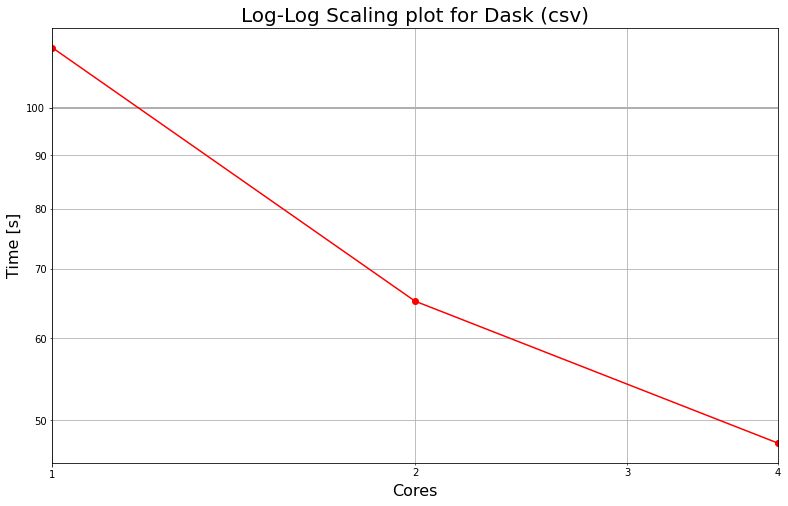

In [11]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.loglog()
for axis in [ax.xaxis, ax.yaxis]:
    formatter = matplotlib.ticker.FormatStrFormatter("%d")
    axis.set_major_formatter(formatter)
    axis.set_minor_formatter(formatter)
ax.grid(visible=True, which='major', linewidth=2)
ax.grid(visible=True, which='minor')
plt.title(f"Log-Log Scaling plot for {dataframe} ({file_format})", fontsize=20)
plt.xlabel("Cores", fontsize=16)
plt.ylabel("Time [s]", fontsize=16)
plt.xlim([1, n_cores])
plt.plot(df["cores"].values, df["time"].values, 'ro-')

plt.savefig(os.path.join("results",f"{dataframe}_scaling.png"), dpi=300)
plt.show()

### Plot Parallel Efficiency as Function of Cores

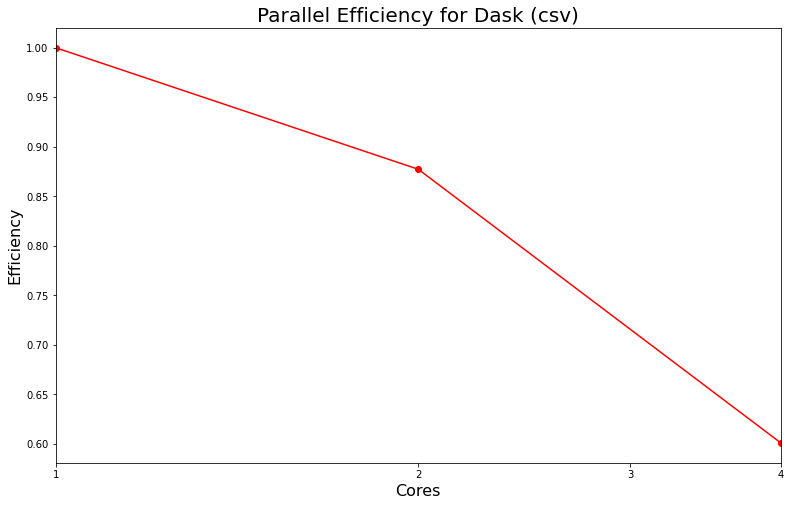

In [12]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_xscale('log')
formatter = matplotlib.ticker.FormatStrFormatter("%d")
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_formatter(formatter)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
                                                         
plt.title(f"Parallel Efficiency for {dataframe} ({file_format})", fontsize=20)
plt.xlabel("Cores", fontsize=16)
plt.ylabel("Efficiency", fontsize=16)
plt.xlim([1, n_cores])
plt.plot(df["cores"].values, df["efficiency"].values, 'ro-')

plt.savefig(os.path.join("results", f"{dataframe}_efficiency.png"), dpi=300)
plt.show()